# Recommendations Systems
## Homework 3: Neural Collaborative Filtering

Submit your solution in the form of an Jupyter notebook file (with extension ipynb).   
Images of graphs or tables should be submitted as PNG or JPG files.   
The code used to answer the questions should be included, runnable and documented in the notebook.   
Python 3.6 should be used.

The goal of this homework is to let you understand the concept of  recommendations based on implicit data which is very common in real life, and learn how ‘Deep neural networks’ components can be used to implement a collaborative filtering and hybrid approach recommenders.  
Implementation example is presented in the <a href='https://colab.research.google.com/drive/1v72_zpCObTFMbNnQXUknoQVXR1vBRX6_?usp=sharing'>NeuralCollaborativeFiltering_Implicit</a> notebook in Moodle.

We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the NeuralCollaborativeFiltering_implicit notebook in Moodle.
<br>

## Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.layers import Embedding, Input, Dense, Reshape,  Flatten, Dropout
from keras.regularizers import l2
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.layers import Multiply, Concatenate

#### Preprocessing:

In [2]:
# !git clone https://github.com/hexiangnan/neural_collaborative_filtering.git

In [3]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training file
training = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.train.rating', sep='\t', names=column_names)

# Read the test file
test_rating = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.rating', sep='\t', names=column_names)


negative_ids = ['(user_id, item_id)']

for i in range(1,100):
    negative_ids.append(f'id-{i}')

test_negative = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.negative', sep='\t', names=negative_ids)

In [4]:
training.loc[(training['user_id'] == 0) & (training['item_id'] == 8)]

,user_id,item_id,rating,timestamp
13,0,8,4,978302268


## Question 1: Dataset preparation

a. This implementation contains one file for training and two files for testing:
- ml-1m.train.rating
- ml-1m.test.rating
- ml-1m.test.negative

**Explain** the role and structure of each file and how it was created from the original MovieLens 1M rating dataset.

##### Answer:

ml-1m.train.rating:
- Training file
- Each line is a training instance: userID\t itemID\t rating\t timestamp (if exists)
- 1 million ratings, where each user has at least 20 ratings
- Similar to the training data from previous HWs

ml-1m.test.rating:
- Test file (positive instances)
- Each line is a testing instance: userID\t itemID\t rating\t timestamp (if exists)

ml-1m.test.negative:
- Test file (negative instances)
- Each line corresponds to the line of test.rating, containing 99 negative samples
- Each line is in the format: (userID,itemID)\t negativeItemID1\t negativeItemID2...
- This is the set of instances the user didn't interact with (rated)
- Only the first cell (userID,itemID) is the user and an item s/he DID interact with
- itemID is the most recent item the user interacted with!

b. **Explain** how the training dataset is created.

##### Answer:

We have the training data (only the positive ratings, none of the negative ones).
We go over the train data and read every tuple of user & item.

Firse, we add the userID to the trainining dataset with a label '1'.

We randomly choose 4 negative items (the "num_negatives" parameter. Can be a differernt number) and add it to the training dataset.
Since the matrix is vary sparse, there is a high probability to randomly choose an index of a negative item.
Then we add it to the trainining dataset with a label '0'.

c. **Explain** how the test dataset is created.

##### Answer:

This is similar to the way the training dataset is constructed, but with data the training dataset this time.

***
## Question 2: Neural Collaborative filtering

In [145]:
from icecream import ic

def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [0]*((num_negatives + 1)*len(train)),[0]*((num_negatives + 1)*len(train)),[1]
    num_users = train.shape[0]
    all_items = training.item_id.unique().argsort()
    
    negatives = [0]*num_negatives
    labels.extend(negatives)
    total_labels = []
    list(map(lambda x: total_labels.extend(labels), range(len(train))))
#     return
    percent_1 = int(len(train)/100)
    ic(percent_1)
    
    items_the_user_didnt_rank = None
    prev_user = -1
    chosen_item_per_user = []
    for idx_i in range(len(train)):
        curr_index = idx_i * (num_negatives + 1)
        if idx_i != 0 and idx_i % percent_1 == 0:
            print(f'{int(idx_i/percent_1)}%')
        u = train.iloc[idx_i].user_id
        i = train.iloc[idx_i].item_id

        user_input[curr_index:curr_index + (num_negatives + 1)] = [u]*(num_negatives + 1)

        item_input[curr_index] = i
        
        if u != prev_user:
            items = training[training['user_id'] == u].item_id.to_numpy().argsort()
            items_the_user_didnt_rank = all_items[~np.in1d(all_items,items)]
            prev_user = u
#             chosen_item_per_user = []

#         items_the_user_didnt_rank = items_the_user_didnt_rank[~np.in1d(items_the_user_didnt_rank,chosen_item_per_user)]
        sample_items = items_the_user_didnt_rank[np.random.choice(len(items_the_user_didnt_rank), size=num_negatives, replace=False)]
        item_input[curr_index+1:curr_index + (num_negatives + 1)] = sample_items
#         chosen_item_per_user.extend(sample_items)

    return user_input, item_input, total_labels

In [146]:
from time import time
start = time()
training_data = get_train_instances(training, num_negatives)
ic(time() - start)

ic| percent_1: 9941


1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%


ic| time() - start: 238.94894123077393


238.94894123077393

In [147]:
user_input, item_input, labels = training_data

In [155]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
training_data_df = pd.DataFrame(list(zip(user_input, item_input, total_labels)), 
               columns =['user_input', 'item_input', 'total_labels'])

In [156]:
training_data_df.to_csv('training_data.csv', index=False)

a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

##### Answer:

In [ ]:
# Add Matrix Factorization (from previous HWs?)
# no need to use it in the assignment anyway. see 2b

In [161]:
def get_GMF_model(num_users, num_items, latent_dim, regs=None, activation='sigmoid'):
    if not regs:
        regs = [[0,0]]
    # Generalized Matrix Factorization
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model


def get_MLP_model(num_users, num_items, latent_dim, regs=None, layers = None, activation='sigmoid'):
    if not regs:
        regs = [[0,0],0,0]
    if not layers:
        layers = [20,10]
    # Multi-Layer Perceptron
    
    assert len(layers) + 1 == len(regs), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])#merge([user_latent, item_latent], mode = 'concat')
    
    # MLP layers
    for idx in range(num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model


def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=None, regs_MLP=None, layers=None, activation='sigmoid'):
    if not reg_GMF:
        reg_GMF=[[0,0]]
    if not regs_MLP:
        regs_MLP=[[0,0],0,0]
    if not layers:
        layers=[20,10]
    # Neural matrix factorization
    assert len(layers) + 1 == len(regs_MLP), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) #merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])#merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    
    for idx in range(num_layer):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

#### Constants:

In [192]:
num_factors = 8 #size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 #how many negative samples per positive sample?
learning_rate = 0.001
batch_size = 256
verbose = 1
epochs = 10
TOP_K = 10
topK = 10 #used to evaluate the model. Top K recommendations are used. 
num_users = len(training_data_df.user_input.unique())
num_items = len(training_data_df.item_input.unique())

In [250]:
# Build models
def build_model():
    mlp_model = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8])
    gmf_model = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
    nmf_model = get_NMF_model(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
    mlp_RELU_model = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8], activation='relu')
    
    mlp_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    gmf_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    nmf_model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    mlp_RELU_model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
   
    return mlp_model, gmf_model, nmf_model, mlp_RELU_model

b. Train and evaluate the recommendations accuracy of three models: 
- MF or GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison.

##### Answer:

Model Evaluation

In [186]:
import math
import heapq # for retrieval topK
import multiprocessing
from time import time
#from numba import jit, autojit


def evaluate_model(model, test_ratings, test_negatives, K):
    """
    Evaluate the performance (MRR, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    mrrs, ndcgs = zip(*[eval_one_rating(model, test_ratings, test_negatives, idx, K) for idx in range(len(test_ratings))])
    return np.array(mrrs).mean(), np.array(ndcgs).mean()


def eval_one_rating(model, test_ratings, test_negatives, idx, K):
    u = test_ratings.iloc[idx].user_id
    gtItem = test_ratings.iloc[idx].item_id
    items = test_negatives[test_negatives['(user_id, item_id)'] == f'({u},{gtItem})'].to_numpy()[0]
    items = items[1:len(items)].astype('int32')
    items = np.append(items, gtItem)
    users = np.full(len(items), u, dtype = 'int32')
    # Get prediction scores
    map_item_score = {}
    predictions = model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    
    items = items[:len(items)-1]
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(K, map_item_score, key=map_item_score.get)
    mrr = getMRR(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    
    return mrr, ndcg


def getMRR(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return 1/(i+1)
    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [170]:
test_rating.head()

,user_id,item_id,rating,timestamp
0,0,25,5,978824351
1,1,133,3,978300174
2,2,207,4,978298504
3,3,208,4,978294282
4,4,222,2,978246585


In [171]:
test_negative.head()

,"(user_id, item_id)",id-1,id-2,id-3,id-4,id-5,id-6,id-7,id-8,id-9,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,id-39,id-40,id-41,id-42,id-43,id-44,id-45,id-46,id-47,id-48,id-49,id-50,id-51,id-52,id-53,id-54,id-55,id-56,id-57,id-58,id-59,id-60,id-61,id-62,id-63,id-64,id-65,id-66,id-67,id-68,id-69,id-70,id-71,id-72,id-73,id-74,id-75,id-76,id-77,id-78,id-79,id-80,id-81,id-82,id-83,id-84,id-85,id-86,id-87,id-88,id-89,id-90,id-91,id-92,id-93,id-94,id-95,id-96,id-97,id-98,id-99
0,"(0,25)",1064,174,2791,3373,269,2678,1902,3641,1216,915,3672,2803,2344,986,3217,2824,2598,464,2340,1952,1855,1353,1547,3487,3293,1541,2414,2728,340,1421,1963,2545,972,487,3463,2727,1135,3135,128,175,2423,1974,2515,3278,3079,1527,2182,1018,2800,1830,1539,617,247,3448,1699,1420,2487,198,811,1010,1423,2840,1770,881,1913,1803,1734,3326,1617,224,3352,1869,1182,1331,336,2517,1721,3512,3656,273,1026,1991,2190,998,3386,3369,185,2822,864,2854,3067,58,2551,2333,2688,3703,1300,1924,3118
1,"(1,133)",1072,3154,3368,3644,549,1810,937,1514,1713,2186,660,2303,2416,670,1176,788,889,3120,2344,2525,3301,2055,1436,2630,11,2773,2176,1847,740,2332,3561,263,3658,3282,1980,2093,3287,3190,3475,569,2315,1442,592,546,3133,1852,2648,934,337,483,1017,3452,467,1183,1765,601,2413,2602,2801,2976,918,753,3540,3341,2973,1580,2118,3511,526,1719,525,1520,486,557,1353,500,2902,1687,1295,2997,2415,797,2518,926,3537,1746,1676,1875,3029,1535,341,3525,1429,2225,1628,2061,469,3056,2553
2,"(2,207)",2216,209,2347,3,1652,3397,383,2905,2284,2866,584,783,3208,1534,2529,1907,1170,3037,2015,1045,3099,3298,2522,739,2652,3702,792,2527,1945,2333,1668,3511,70,1991,3071,2474,1629,3221,505,3266,1475,515,2704,1717,569,3248,241,2643,2137,2336,2627,2618,2748,2967,2579,1732,3283,1440,1052,1906,1812,1182,2831,1548,1630,2227,2352,760,350,302,791,300,3528,1444,2,798,997,376,2565,1565,718,710,2695,904,3643,655,3666,3069,3661,953,865,813,1353,2945,2580,2989,2790,2879,2481
3,"(3,208)",3023,1489,1916,1706,1221,1191,2671,81,2483,941,841,1617,1437,2700,1904,1763,1181,599,2442,1656,1370,1171,1372,1444,1596,2023,1456,2179,530,1949,2628,290,1996,2593,2489,3484,1035,2826,1274,595,1151,634,435,2738,3013,2605,3401,3595,2450,2052,15,501,1958,988,1920,1798,604,2793,2063,3655,3073,557,2007,1937,2244,55,1016,2382,2506,3501,914,3127,23,3187,799,2572,1038,3028,2619,1429,2623,2158,2785,3674,2578,1837,1689,296,959,3347,1707,2901,2767,2167,1921,247,1618,2016,2323
4,"(4,222)",1794,3535,108,593,466,2048,854,1378,1301,697,1376,22,2135,3657,3173,1322,976,6,1399,817,2757,2010,652,458,1227,204,592,2875,1930,2251,1654,2542,1149,3089,454,2466,3461,1770,3106,2275,1100,906,1814,421,2418,866,3607,821,213,432,34,2578,2517,2221,2818,2420,2738,2141,3013,3610,959,1927,2524,932,3327,187,2575,1674,557,2547,1572,776,1600,2682,2085,1987,1390,614,3098,1831,927,2285,1059,2850,3517,134,1852,2776,1694,2490,1332,2526,2804,2027,833,176,463,2851,2453


In [329]:
mlp_model, gmf_model, nmf_model, _ = build_model()

models = [('GMF', gmf_model), ('MLP', mlp_model), ('NMF', nmf_model)]
TOP_K = 10

def evalute_base_line_model():
    for top_k in [5,10]:    
        for name, model in models:
            t1 = time()
            mrr, ndcg = evaluate_model(model, test_rating, test_negative, top_k)
            print(f'{name}, k: {top_k}, Init: MRR = {mrr:.4f}, NDCG = {ndcg:.4f}\t t1 = [{(time()-t1)/60}s]')
    
evalute_base_line_model()

GMF, k: 5, Init: MRR = 0.0220, NDCG = 0.0287	 t1 = [2.7620137373606366s]
MLP, k: 5, Init: MRR = 0.0224, NDCG = 0.0284	 t1 = [2.7175755858421327s]
NMF, k: 5, Init: MRR = 0.0273, NDCG = 0.0353	 t1 = [2.7486093004544574s]
GMF, k: 10, Init: MRR = 0.0281, NDCG = 0.0436	 t1 = [2.8460166494051617s]
MLP, k: 10, Init: MRR = 0.0284, NDCG = 0.0432	 t1 = [2.807937916119893s]
NMF, k: 10, Init: MRR = 0.0338, NDCG = 0.0513	 t1 = [2.8387774864832562s]


In [197]:
mrr_GMF = 0.0267
mrr_MLP = 0.0289
mrr_NMF = 0.0285

ndcg_GMF = 0.0424
ndcg_MLP = 0.0449
ndcg_NMF = 0.0436

In [203]:
# Train model
mlp_model, gmf_model, nmf_model, _ = build_model()


models_and_input = [('GMF', gmf_model, mrr_GMF, ndcg_GMF), ('MLP', mlp_model, mrr_MLP, ndcg_MLP), ('NMF', nmf_model, mrr_NMF, ndcg_NMF)]
for model_and_input in models_and_input:
    for top_k in [5, 10]:
        model_name, model, mrr, ndcg = model_and_input
        best_mrr, best_ndcg, best_iter = mrr, ndcg, -1
        print(f"Running on Model: {model_name}, using top_k: {top_k}")
        
        for epoch in range(epochs):
            t1 = time()
            # Generate training instances
            
            # Training
            print("Training")
            hist = model.fit([np.array(user_input), np.array(item_input)], #input
                             np.array(labels), # labels 
                             batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
            print("Finished training")            
            t2 = time()

            # Evaluation
            print("Evaluating") 
            if epoch % verbose == 0:
                mrr, ndcg = evaluate_model(model, test_rating, test_negative, top_k)
                loss = hist.history['loss'][0]
                print(f'Iteration {epoch} [{t2-t1:.1f} s]: MRR = {mrr:.4f}, NDCG = {ndcg:.4f}, loss = {loss:.4f} [{time()-t2:.1f} s]')
                if mrr > best_mrr:
                    best_mrr, best_ndcg, best_iter = mrr, ndcg, epoch
            print(f"---------End Epoch: {epoch}---------")
        print(f"End. Best Iteration {best_iter}:  MRR = {best_mrr:.4f}, NDCG = {best_ndcg:.4f}. ")

Running on Model: GMF, using top_k: 5
Training
Finished training
Evaluating
Iteration 0 [14.9 s]: MRR = 0.1275, NDCG = 0.1595, loss = 0.3471 [181.8 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 1 [14.6 s]: MRR = 0.1381, NDCG = 0.1756, loss = 0.3110 [181.9 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 2 [13.6 s]: MRR = 0.1507, NDCG = 0.1933, loss = 0.2943 [179.3 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 3 [15.7 s]: MRR = 0.1607, NDCG = 0.2055, loss = 0.2838 [180.3 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 4 [13.9 s]: MRR = 0.1663, NDCG = 0.2121, loss = 0.2777 [185.1 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 5 [14.3 s]: MRR = 0.1669, NDCG = 0.2134, loss = 0.2745 [178.3 s]
---------End Epoc: {epoch}---------
Training
Finished training
Evaluating
Iteration 6 [22.7 s]: MRR = 0.

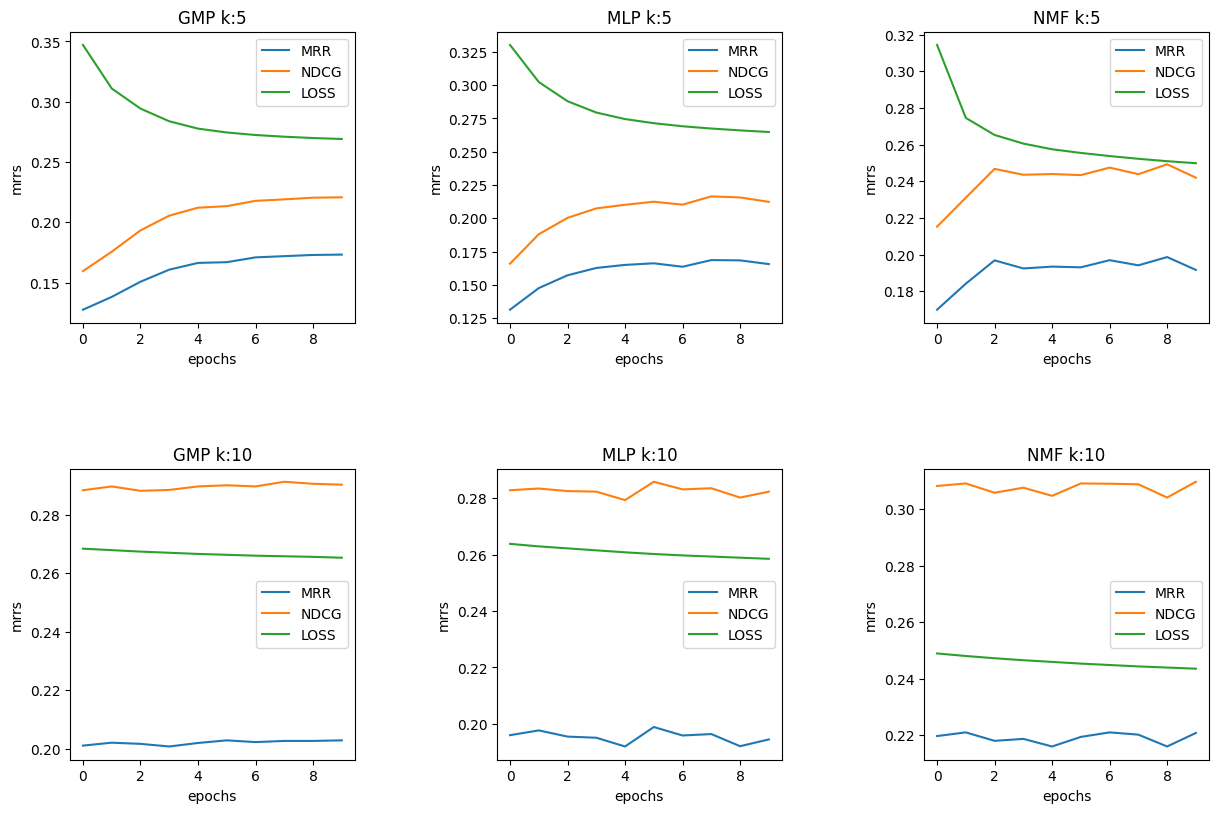

In [266]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
files = ['results_GMP_5.txt', 'results_GMP_10.txt', 'results_MLP_5.txt', 'results_MLP_10.txt', 'results_NMF_5.txt', 'results_NMF_10.txt']
display_df_list = []

mrrs_all_algo = []
ndcg_all_algo = []
loss_all_algo = []
for f_name in files:
    mrrs, ndcgs, losss = [], [], []
    with open(f_name, 'r') as f:
        for l in f:
            mrr, ndcg, loss = l.split(',')
            mrrs.append(float(mrr.split(' = ')[1].strip()))
            ndcgs.append(float(ndcg.split(' = ')[1].strip()))
            losss.append(float(loss.split(' = ')[1].strip()))
        epochs = list(range(len(mrrs)))
        
       
        name = ' k:'.join(f_name.split('.')[0].split('_')[1:3])
        mrrs_all_algo.append((name, mrrs))
        ndcg_all_algo.append((name, ndcgs))
        loss_all_algo.append((name, losss))  
        
        display_df = pd.DataFrame(list(zip(mrrs, ndcgs, losss, epochs)), 
               columns =['mrrs', 'ndcgs', 'losss', 'epochs'])
        display_df_list.append((name,display_df))

fig = plt.figure()
fig.subplots_adjust(top=0.92, bottom=0.01, left=0.0010, right=0.95, hspace=0.5,
                    wspace=0.5)

order_of_i = [1,4,2,5,3,6]
for i in np.arange(1, 7):
    ax = fig.add_subplot(2, 3, order_of_i[i-1])
    name, display_df = display_df_list[i-1]
    sns.lineplot(x=display_df.epochs , y = display_df.mrrs,ax=ax, label="MRR")
    sns.lineplot(x=display_df.epochs , y = display_df.ndcgs,ax=ax, label="NDCG")
    sns.lineplot(x=display_df.epochs , y = display_df.losss,ax=ax, label="LOSS")
    ax.set_title(name)
    ax.legend()

plt.show()

c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. 
What are the difference in preparing the dataset for evaluation.

##### Answer:

d. How will you measure item similarity using the NeuMF model?

##### Answer:

text...

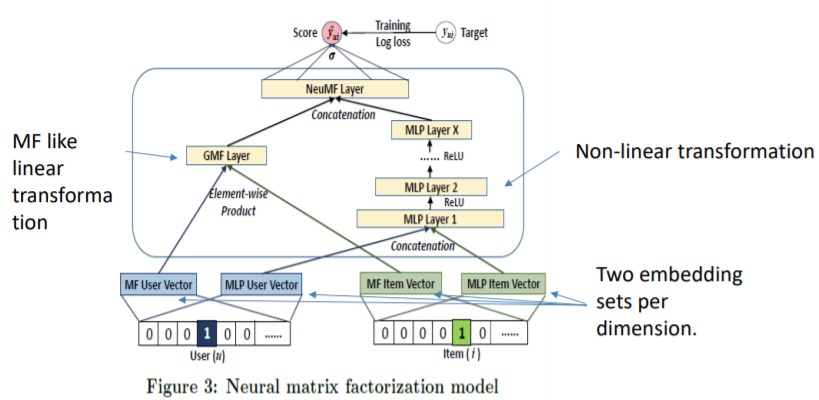

<br>

***
## Question 3: Loss function

a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a Mean Squared Error and the activation function of the last layer to RELU.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

In [327]:
_, _, _, mlp_RELU_model = build_model()
mlp_RELU_model.summary()

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
___________________________________________________________________________________________

In [328]:
models = [('MLP_RELU', mlp_RELU_model)]

def evalute_base_line_model():
    for top_k in [5,10]:
        for name, model in models:
            t1 = time()
            mrr, ndcg = evaluate_model(model, test_rating, test_negative, top_k)
            print(f'{name}, k: {top_k}, Init: MRR = {mrr:.4f}, NDCG = {ndcg:.4f}\t t1 = [{(time()-t1)/60}s]')
    
evalute_base_line_model()

MLP_RELU, k: 5, Init: MRR = 0.0231, NDCG = 0.0298	 t1 = [2.7605172475179036s]
MLP_RELU, k: 10, Init: MRR = 0.0298, NDCG = 0.0463	 t1 = [2.811696235338847s]


In [254]:
mrr_MLP_RELU = 0.0260
ndcg_MLP_RELU = 0.0387

In [256]:
# Train model
_, _, _, mlp_RELU_model = build_model()

epochs = 10
models_and_input = [('MLP_RELU', mlp_RELU_model, mrr_MLP_RELU, ndcg_MLP_RELU)]

for model_and_input in models_and_input:
    for top_k in [5, 10]:
        model_name, model, mrr, ndcg = model_and_input
        best_mrr, best_ndcg, best_iter = mrr, ndcg, -1
        print(f"Running on Model: {model_name}, using top_k: {top_k}")
        
        for epoch in range(epochs):
            t1 = time()
            # Generate training instances
            
            # Training
            print("Training")
            hist = model.fit([np.array(user_input), np.array(item_input)], #input
                             np.array(labels), # labels 
                             batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
            print("Finished training")            
            t2 = time()

            # Evaluation
            print("Evaluating") 
            if epoch % verbose == 0:
                mrr, ndcg = evaluate_model(model, test_rating, test_negative, top_k)
                loss = hist.history['loss'][0]
                print(f'Iteration {epoch} [{t2-t1:.1f} s]: MRR = {mrr:.4f}, NDCG = {ndcg:.4f}, loss = {loss:.4f} [{time()-t2:.1f} s]')
                if mrr > best_mrr:
                    best_mrr, best_ndcg, best_iter = mrr, ndcg, epoch
            print(f"---------End Epoch: {epoch}---------")
        print(f"End. Best Iteration {best_iter}:  MRR = {best_mrr:.4f}, NDCG = {best_ndcg:.4f}. ")

Running on Model: MLP_RELU, using top_k: 5
Training
Finished training
Evaluating
Iteration 0 [14.5 s]: MRR = 0.1397, NDCG = 0.1755, loss = 0.1020 [158.6 s]
---------End Epoch: 0---------
Training
Finished training
Evaluating
Iteration 1 [12.6 s]: MRR = 0.1591, NDCG = 0.2016, loss = 0.0933 [157.4 s]
---------End Epoch: 1---------
Training
Finished training
Evaluating
Iteration 2 [12.8 s]: MRR = 0.1640, NDCG = 0.2063, loss = 0.0889 [156.9 s]
---------End Epoch: 2---------
Training
Finished training
Evaluating
Iteration 3 [13.3 s]: MRR = 0.1730, NDCG = 0.2164, loss = 0.0867 [157.2 s]
---------End Epoch: 3---------
Training
Finished training
Evaluating
Iteration 4 [12.6 s]: MRR = 0.1775, NDCG = 0.2227, loss = 0.0854 [157.6 s]
---------End Epoch: 4---------
Training
Finished training
Evaluating
Iteration 5 [13.1 s]: MRR = 0.1774, NDCG = 0.2240, loss = 0.0845 [157.6 s]
---------End Epoch: 5---------
Training
Finished training
Evaluating
Iteration 6 [12.5 s]: MRR = 0.1699, NDCG = 0.2163, loss

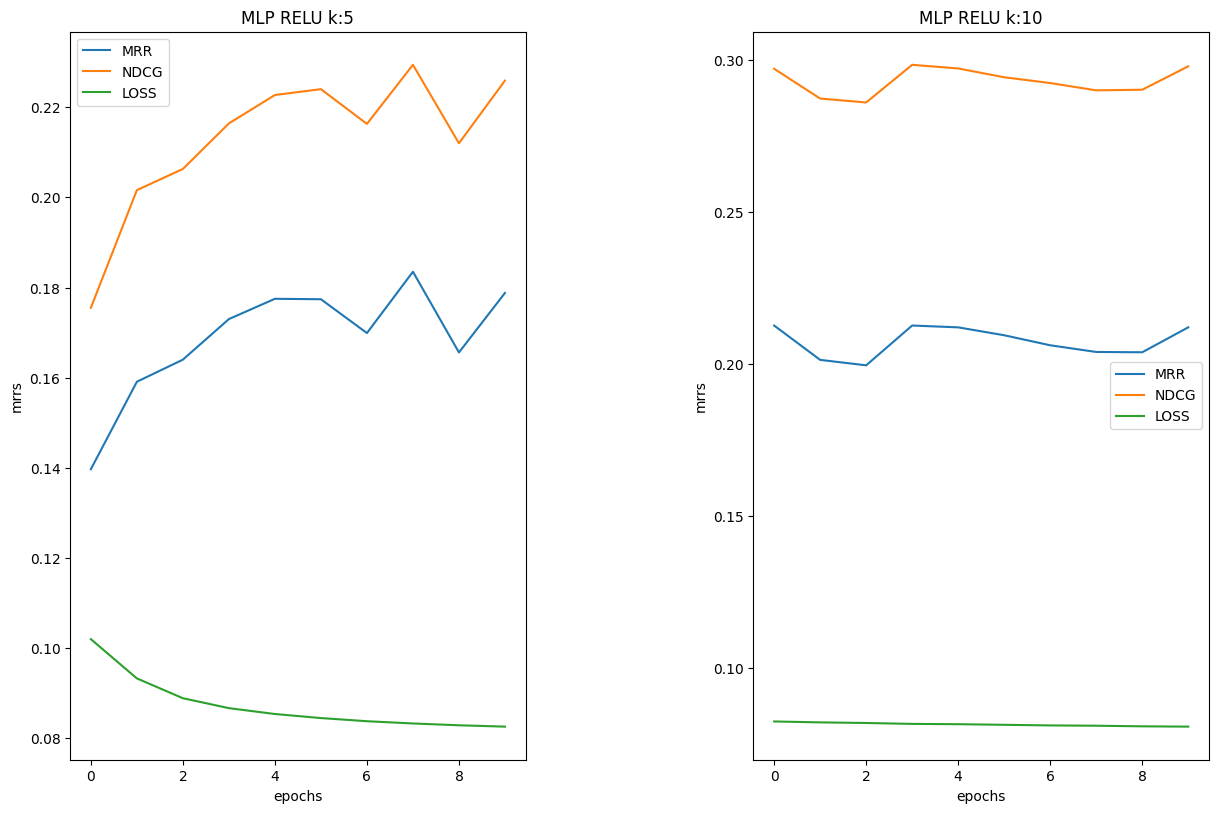

In [267]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
files = ['results_MLP_RELU_5.txt', 'results_MLP_RELU_10.txt']
display_df_list = []
for f_name in files:
    mrrs, ndcgs, losss = [], [], []
    with open(f_name, 'r') as f:
        for l in f:
            mrr, ndcg, loss = l.split(',')
            mrrs.append(float(mrr.split(' = ')[1].strip()))
            ndcgs.append(float(ndcg.split(' = ')[1].strip()))
            losss.append(float(loss.split(' = ')[1].strip()))
        
        epochs = list(range(len(mrrs)))
        f_name.split('.')[0].split('_')[1:4]
        name = 'MLP RELU k:{}'.format(f_name.split('.')[0].split('_')[3])
        mrrs_all_algo.append((name, mrrs))
        ndcg_all_algo.append((name, ndcgs))
        loss_all_algo.append((name, losss))           
        display_df = pd.DataFrame(list(zip(mrrs, ndcgs, losss, epochs)), 
               columns =['mrrs', 'ndcgs', 'losss', 'epochs'])
        display_df_list.append((name,display_df))

fig = plt.figure()
fig.subplots_adjust(top=0.92, bottom=0.01, left=0.0010, right=0.95, hspace=0.5,
                    wspace=0.5)

order_of_i = [1,2]
for i in np.arange(1, 3):
    ax = fig.add_subplot(1, 2, order_of_i[i-1])
    name, display_df = display_df_list[i-1]
    sns.lineplot(x=display_df.epochs , y = display_df.mrrs,ax=ax, label="MRR")
    sns.lineplot(x=display_df.epochs , y = display_df.ndcgs,ax=ax, label="NDCG")
    sns.lineplot(x=display_df.epochs , y = display_df.losss,ax=ax, label="LOSS")
    ax.set_title(name)
    ax.legend()

plt.show()

In [306]:
names = [a[0] for a in mrrs_all_algo]
mrr_lists = [a[1] for a in mrrs_all_algo]

display_mrr_df = pd.DataFrame(list(zip(*mrr_lists)), 
       columns=names)
display_mrr_df['epochs'] = epochs


In [309]:
names = [a[0] for a in ndcg_all_algo]
ndcg_lists = [a[1] for a in ndcg_all_algo]

display_ndcg_df = pd.DataFrame(list(zip(*ndcg_lists)), 
       columns=names)
display_ndcg_df['epochs'] = epochs


In [310]:
names = [a[0] for a in loss_all_algo]
loss_lists = [a[1] for a in loss_all_algo]

display_loss_df = pd.DataFrame(list(zip(*loss_lists)), 
       columns=names)
display_loss_df['epochs'] = epochs


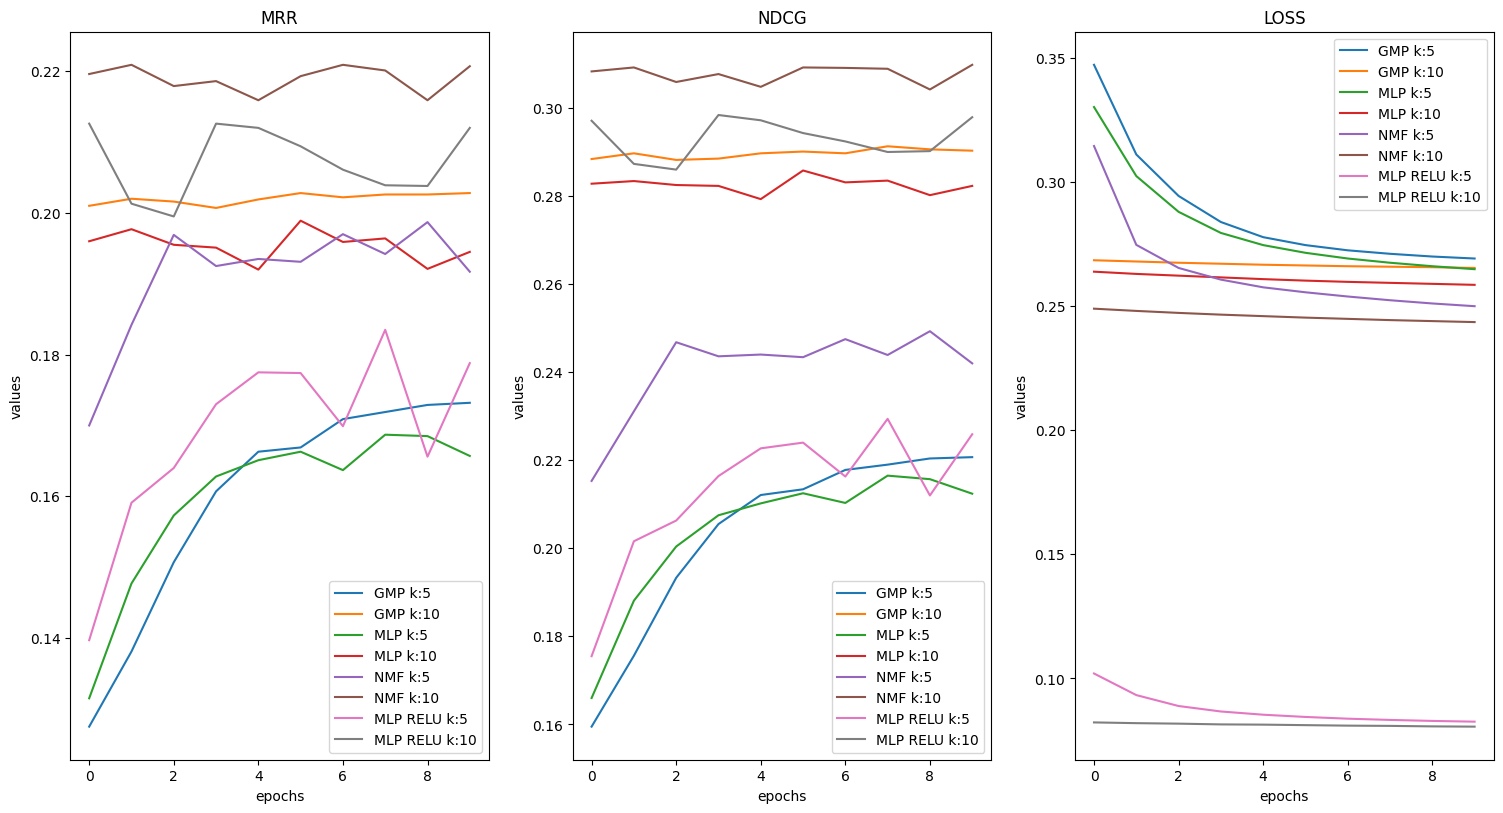

In [325]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100

fig = plt.figure()
fig.subplots_adjust(top=0.92, bottom=0.01, left=0.0010, right=0.95, hspace=0.1,
                    wspace=0.2)

columns = list(display_df.columns)[:-1]


for i, display_df in enumerate([display_mrr_df, display_ndcg_df, display_loss_df], start=1):
    ax = fig.add_subplot(1, 3, i)
    for j in range(len(columns)):
        sns.lineplot(x=display_df.epochs , y = display_df[columns[j]], ax=ax, label=columns[j])
    plt.ylabel('values')
    if i == 1:
        ax.set_title("MRR")
    if i == 2:
        ax.set_title("NDCG")
    if i == 3:
        ax.set_title("LOSS")        
ax.legend()    
plt.show()
